In [123]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re 
import gensim
import pickle # Useful for storing big datasets
import nltk
from nltk.stem import *
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression


### Helper functions

In [3]:
# function to group dataset by features when rows can belong to multiple groups
def groupby_many(data, groups):
    """
    Groups a Series or DataFrame object where each row can belong to many groups.

    Parameters
    ----------
    data : Series or DataFrame
        The data to group
    groups : iterable of iterables
        For each row in data, the groups that row belongs to.
        A row can belong to zero, one, or multiple groups.

    Returns
    -------
    A GroupBy object    
    """ 
    pairs = [(i, g) for (i, gg) in enumerate(groups) for g in gg]
    row, group = zip(*pairs)
    return data.iloc[list(row)].groupby(list(group))


def draw_plot1(year):
    df=movies
    df=df[df['year']==year]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top genres of each year')


def draw_plot2(genre):
    df=movies
    df=df[df['genres'].apply(lambda x: genre in x)]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['countries'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top countries for each genre')


# def draw_plot3(year):
#     df=movies
#     df=df[df['year']==year]
#     fig, axs = plt.subplots(1)
#     groupby_many(df, df['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:blue',legend=True)
#     # groupby_many(df, df['genres'])[['revenue']].mean().sort_values('revenue',ascending=False)['revenue'][0:20].plot(kind='bar',ax=axs[1],color='tab:green',legend=True)

#     # for ax in fig.get_axes():
#     #     ax.label_outer()

#     plt.title('plot of richest genre of the year')


# def draw_plot4(genre):
#     df=movies_with_revenues
#     df=df[df['genres'].apply(lambda x: genre in x)]
#     fig, axs = plt.subplots(1)
#     groupby_many(df, df['countries'])[['revenue']].mean().sort_values('revenue',ascending=False)['revenue'][0:20].plot(kind='bar',color='tab:red',legend=True)
#     #groupby_many(df, df['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
#     for ax in fig.get_axes():
#         ax.label_outer()
#     plt.title('Best countries for each genre')

### Loading the data and naming the columns 

In [4]:
path = 'MovieSummaries/'

character=pd.read_csv(path+'character.metadata.tsv',sep='\t',header=None, names=['wiki_movie_ID','Freebase_movie_ID','release_date','character_name','actor_birth','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])
cmu_movies = pd.read_csv(path+'movie.metadata.tsv',sep='\t',header=None,names=['wiki_movie_ID','Freebase_movie_ID','movie_name','date','revenue','runtime','languages','countries','genres'])
plot_summary = pd.read_csv(path+'plot_summaries.txt',sep='\t',header=None,names=['wiki_movie_ID','summary'])
imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
ratings = pd.read_csv(path+'rating.tsv',sep='\t')
complementary_data = pd.read_csv(path+'complementary_data.csv')


<ipython-input-4-e9e6f5f505b1>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
<ipython-input-4-e9e6f5f505b1>:8: DtypeWarning: Columns (0,1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  complementary_data = pd.read_csv(path+'complementary_data.csv')


In [5]:
display('CHARACTERS:', character.head())
display('CMU MOVIES:',cmu_movies.head())
display('PLOT SUMMARIES:',plot_summary.head())
display('IMDB MOVIES:',imdb_movies.head())
display('RATINGS:',ratings.head())
display('COMPLEMENTARY:',complementary_data.head())

'CHARACTERS:'

,wiki_movie_ID,Freebase_movie_ID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


'CMU MOVIES:'

,wiki_movie_ID,Freebase_movie_ID,movie_name,date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


'PLOT SUMMARIES:'

,wiki_movie_ID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


'IMDB MOVIES:'

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


'RATINGS:'

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


'COMPLEMENTARY:'

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,69.0,suomi,Released,NaN,Ariel,7.1,40.0,2.0,1.0,2.0
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,76.0,English,Released,NaN,Shadows in Paradise,7.0,32.0,1.0,1.0,3.0
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,...,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485.0,2.0,1.0,1.0
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,...,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69.0,3.0,2.0,1.0
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,...,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4.0,1.0,1.0,5.0


In [6]:
#   UNIQUE MOVIE NAMES
print('Number of different movie names in CMU dataset : ',len(cmu_movies.movie_name.unique()))
print('Number of different movie names in IMDb dataset : ',len(imdb_movies.originalTitle.unique()))

Number of different movie names in CMU dataset :  75478
Number of different movie names in IMDb dataset :  4305335


In [7]:
# Create 2 features for the month and the year of releasing of the movies
cmu_movies['month_day'] = cmu_movies['date'].apply(lambda x: x[5:] if len(str(x))>3 else np.nan)
cmu_movies['year'] = cmu_movies['date'].apply(lambda x: x[0:4] if len(str(x))>3 else x)
cmu_movies=cmu_movies.drop('date', axis = 1)

### Merging CMU and IMDB datasets

In [8]:
merged_movies = cmu_movies.merge(imdb_movies,left_on=['movie_name', 'year'],right_on=['primaryTitle', 'startYear'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)


Size of the new dataset :  (61081, 19)


In [9]:
#adding the ratings feature
movies_with_ratings= merged_movies.merge(ratings, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)

Size of the dataset with the ratings :  (50834, 21)


In [10]:
movies_with_ratings.head()

,wiki_movie_ID,Freebase_movie_ID,movie_name,revenue,runtime,languages,countries,genres_x,month_day,year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,55237
1,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.9,19
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",,1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.7,40
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",,1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,6.0,590
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",05-29,1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16


### Pre-process the data : cleaning, engineering and standardizing

In [11]:
#Dropping useless or redundant features
movies_with_ratings = movies_with_ratings.drop('genres_y', axis = 1)
movies_with_ratings = movies_with_ratings.rename(columns = {'genres_x':'genres'})
movies_with_ratings = movies_with_ratings.drop('Freebase_movie_ID', axis = 1)
movies_with_ratings = movies_with_ratings.drop('primaryTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('originalTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('runtimeMinutes', axis = 1)
movies_with_ratings = movies_with_ratings.drop('startYear', axis = 1)

movies_with_ratings['year']=movies_with_ratings['year'].astype(int)

In [12]:
#Remove the 'key' part of languages, countries and genres features
movies_with_ratings['languages'] = movies_with_ratings['languages'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['countries'] = movies_with_ratings['countries'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['genres'] = movies_with_ratings['genres'].apply(lambda x: list(json.loads(x).values()))

In [13]:
print('The percentage of null values for the feature endYear is', np.array(movies_with_ratings.endYear == '\\N').sum()/movies_with_ratings.shape[0])

The percentage of null values for the feature endYear is 0.993390250619664


The percentage of rows containing the feature endYear is very low, so we remove this feature.

In [14]:
movies_with_ratings = movies_with_ratings.drop('endYear', axis = 1)

In [15]:
#removing movies with no votes
movies_with_ratings = movies_with_ratings[movies_with_ratings['numVotes']>0]

In [16]:
movies_with_ratings.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237
1,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0594845,tvEpisode,0,7.9,19
2,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40
3,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590
4,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16


In [257]:
#adding the budget feature
movies= movies_with_ratings.merge(complementary_data[['imdb_id','budget', 'popularity']], left_on='tconst', right_on='imdb_id', how='inner')
print('Size of the dataset with the ratings : ', movies.shape)

Size of the dataset with the ratings :  (42636, 17)


In [258]:
#adding profit column
movies['budget'] = movies['budget'].astype(float)
movies['revenue'] = movies['revenue'].astype(float)
movies['profit'] = movies['revenue'] - movies['budget']
movies.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,-13989168.0
1,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40,tt0094806,0.0,1.80E-05,NaN
2,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590,tt0083949,0.0,0.123849,NaN
3,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16,tt0002894,0.0,0.000347,NaN
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,1600000.0


In [259]:
movies=movies[movies.revenue>0]
movies=movies[movies.budget!=0]
display(movies)

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,-13989168.0
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,1600000.0
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",11-08,1989,tt0097499,movie,0,7.5,30168,tt0097499,9000000.0,1.161514,1161099.0
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",08-27,1964,tt0058331,movie,0,7.8,173216,tt0058331,6000000.0,4.882687,96272727.0
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",06-27,2001,tt0255819,movie,0,6.4,14988,tt0255819,16000000.0,1.07838,13381649.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42575,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Thriller, Disaster, Action, Action/Adventure]",01-10,1997,tt0120390,movie,0,4.9,11923,tt0120390,55000000.0,1.640388,-43461765.0
42593,303933,Twister,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",05-10,1996,tt0117998,movie,0,6.4,197492,tt0117998,92000000.0,3.535778,402471524.0
42594,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",03-11,2011,tt0945513,movie,0,7.5,520621,tt0945513,32000000.0,4.41211,115332697.0
42612,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",06-29,1988,tt0094898,movie,0,7.1,208557,tt0094898,39000000.0,2.50055,249752301.0


In [260]:
movies["weighted_rating"]=movies.numVotes.apply(np.log10)*movies.averageRating


In [261]:
##or instead if we choose popularity
#movies["weighted_rating"]=movies.popularity*movies.averageRating


In [262]:
COLUMNS = ['profit', 'weighted_rating']

for i in range(len(COLUMNS)):
     movies[COLUMNS] = (movies[COLUMNS] - movies[COLUMNS].mean())/(movies[COLUMNS].std())



#### Sucess Metric

In [263]:
movies["success"]= (movies.weighted_rating+movies.profit)/2

In [264]:
movies.success.describe()

count    3.681000e+03
mean    -9.651491e-18
std      8.418216e-01
min     -1.827881e+00
25%     -5.288955e-01
50%     -1.266296e-01
75%      3.721302e-01
max      1.088298e+01
Name: success, dtype: float64

#### We will now check for non unicity of the movies in the dataset:

In [265]:
duplicates = movies.loc[movies.duplicated(subset=['wiki_movie_ID', 'titleType'], keep = False)]

In [266]:
duplicates.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit,weighted_rating,success
36167,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0804443,movie,0,4.0,3783,tt0804443,22000000.0,0.357426,-0.068944,-2.102580,-1.085762
36168,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0856162,movie,0,6.3,83,tt0856162,4000.0,0.000576,0.104498,-2.386051,-1.140776


We will consider as duplicates the movies having same title and titleType. Our strategy is to drop duplicates, keeping the movie with the highest 'popularity', i.e. highest vote count

In [267]:
for i in range(len(duplicates.wiki_movie_ID.unique())):# for loop per each duplicate
    orig = movies[movies.wiki_movie_ID == duplicates.wiki_movie_ID.unique()[i]] # find them in the original dataset
    movies = movies.drop(list(orig[orig.numVotes !=orig.numVotes.max()].index)) # drop rows that don't have the maximum number of votes


In [268]:
#there are movies with the same Id but different titleType and rating
movies.loc[movies.duplicated(subset=['wiki_movie_ID'], keep = False)].head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit,weighted_rating,success
7839,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0407304,movie,0,6.5,449303,tt0407304,132000000.0,5.685105,3.183340,0.760032,1.971686
7840,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0449040,video,0,3.2,2656,tt0449040,1000000.0,0.571862,4.216298,-2.530605,0.842847


In [269]:
#keep only principal genres 

principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']

def common_data(list1, list2):
    a_set = set(list1)
    b_set = set(list2)
    intersec = a_set.intersection(b_set)
    if len(intersec) > 0:
        return list(intersec)
    else : 
        return 0
        


movies['genres']= movies['genres'].apply(lambda x: common_data(x,principal_genres))
movies = movies[movies['genres']!=0]
display(movies)


,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit,weighted_rating,success
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Thriller, Horror, Action]",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,-0.552144,-0.963467,-0.757805
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],[Comedy],08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,-0.429220,-0.992895,-0.711058
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],[Drama],11-08,1989,tt0097499,movie,0,7.5,30168,tt0097499,9000000.0,1.161514,-0.432681,0.358668,-0.037006
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Comedy, Fantasy, Drama]",08-27,1964,tt0058331,movie,0,7.8,173216,tt0058331,6000000.0,4.882687,0.317291,1.285773,0.801532
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],[Drama],06-27,2001,tt0255819,movie,0,6.4,14988,tt0255819,16000000.0,1.07838,-0.336320,-0.518339,-0.427329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,10149834,Ponyo,202614288.0,101.0,[Japanese Language],[Japan],"[Fantasy, Drama]",07-19,2008,tt0876563,movie,0,7.6,144403,tt0876563,41677699.0,4.196854,0.827177,1.075424,0.951301
42575,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Thriller, Action]",01-10,1997,tt0120390,movie,0,4.9,11923,tt0120390,55000000.0,1.640388,-0.784540,-1.379856,-1.082198
42594,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Science Fiction, Thriller, Drama, Action]",03-11,2011,tt0945513,movie,0,7.5,520621,tt0945513,32000000.0,4.41211,0.467583,1.542670,1.005126
42612,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Comedy, Romance Film, Drama]",06-29,1988,tt0094898,movie,0,7.1,208557,tt0094898,39000000.0,2.50055,1.527505,0.890844,1.209175


### Visualization of the data

In [270]:
#plot of the top 20 languages 
languages_20 = groupby_many(movies, movies['languages'])[['success']].mean().sort_values('success', ascending=False)[0:20]
display(languages_20)

,success
Old English language,3.505717
Amharic Language,2.574135
Assyrian language,2.574135
Sicilian Language,2.527750
Nepali Language,2.487876
Pawnee Language,2.169453
Zulu Language,2.004234
Xhosa Language,2.004234
Croatian language,1.832413
Hmong language,1.792573


#### Distributions

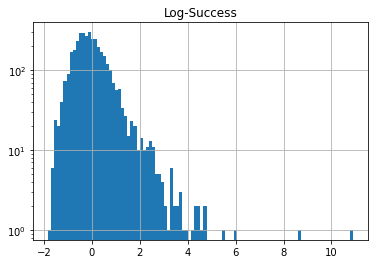

In [271]:
fig, axes = plt.subplots(1, 1)

movies.success.hist(bins=100, log=True)
axes.set_title('Log-Success')
plt.show()

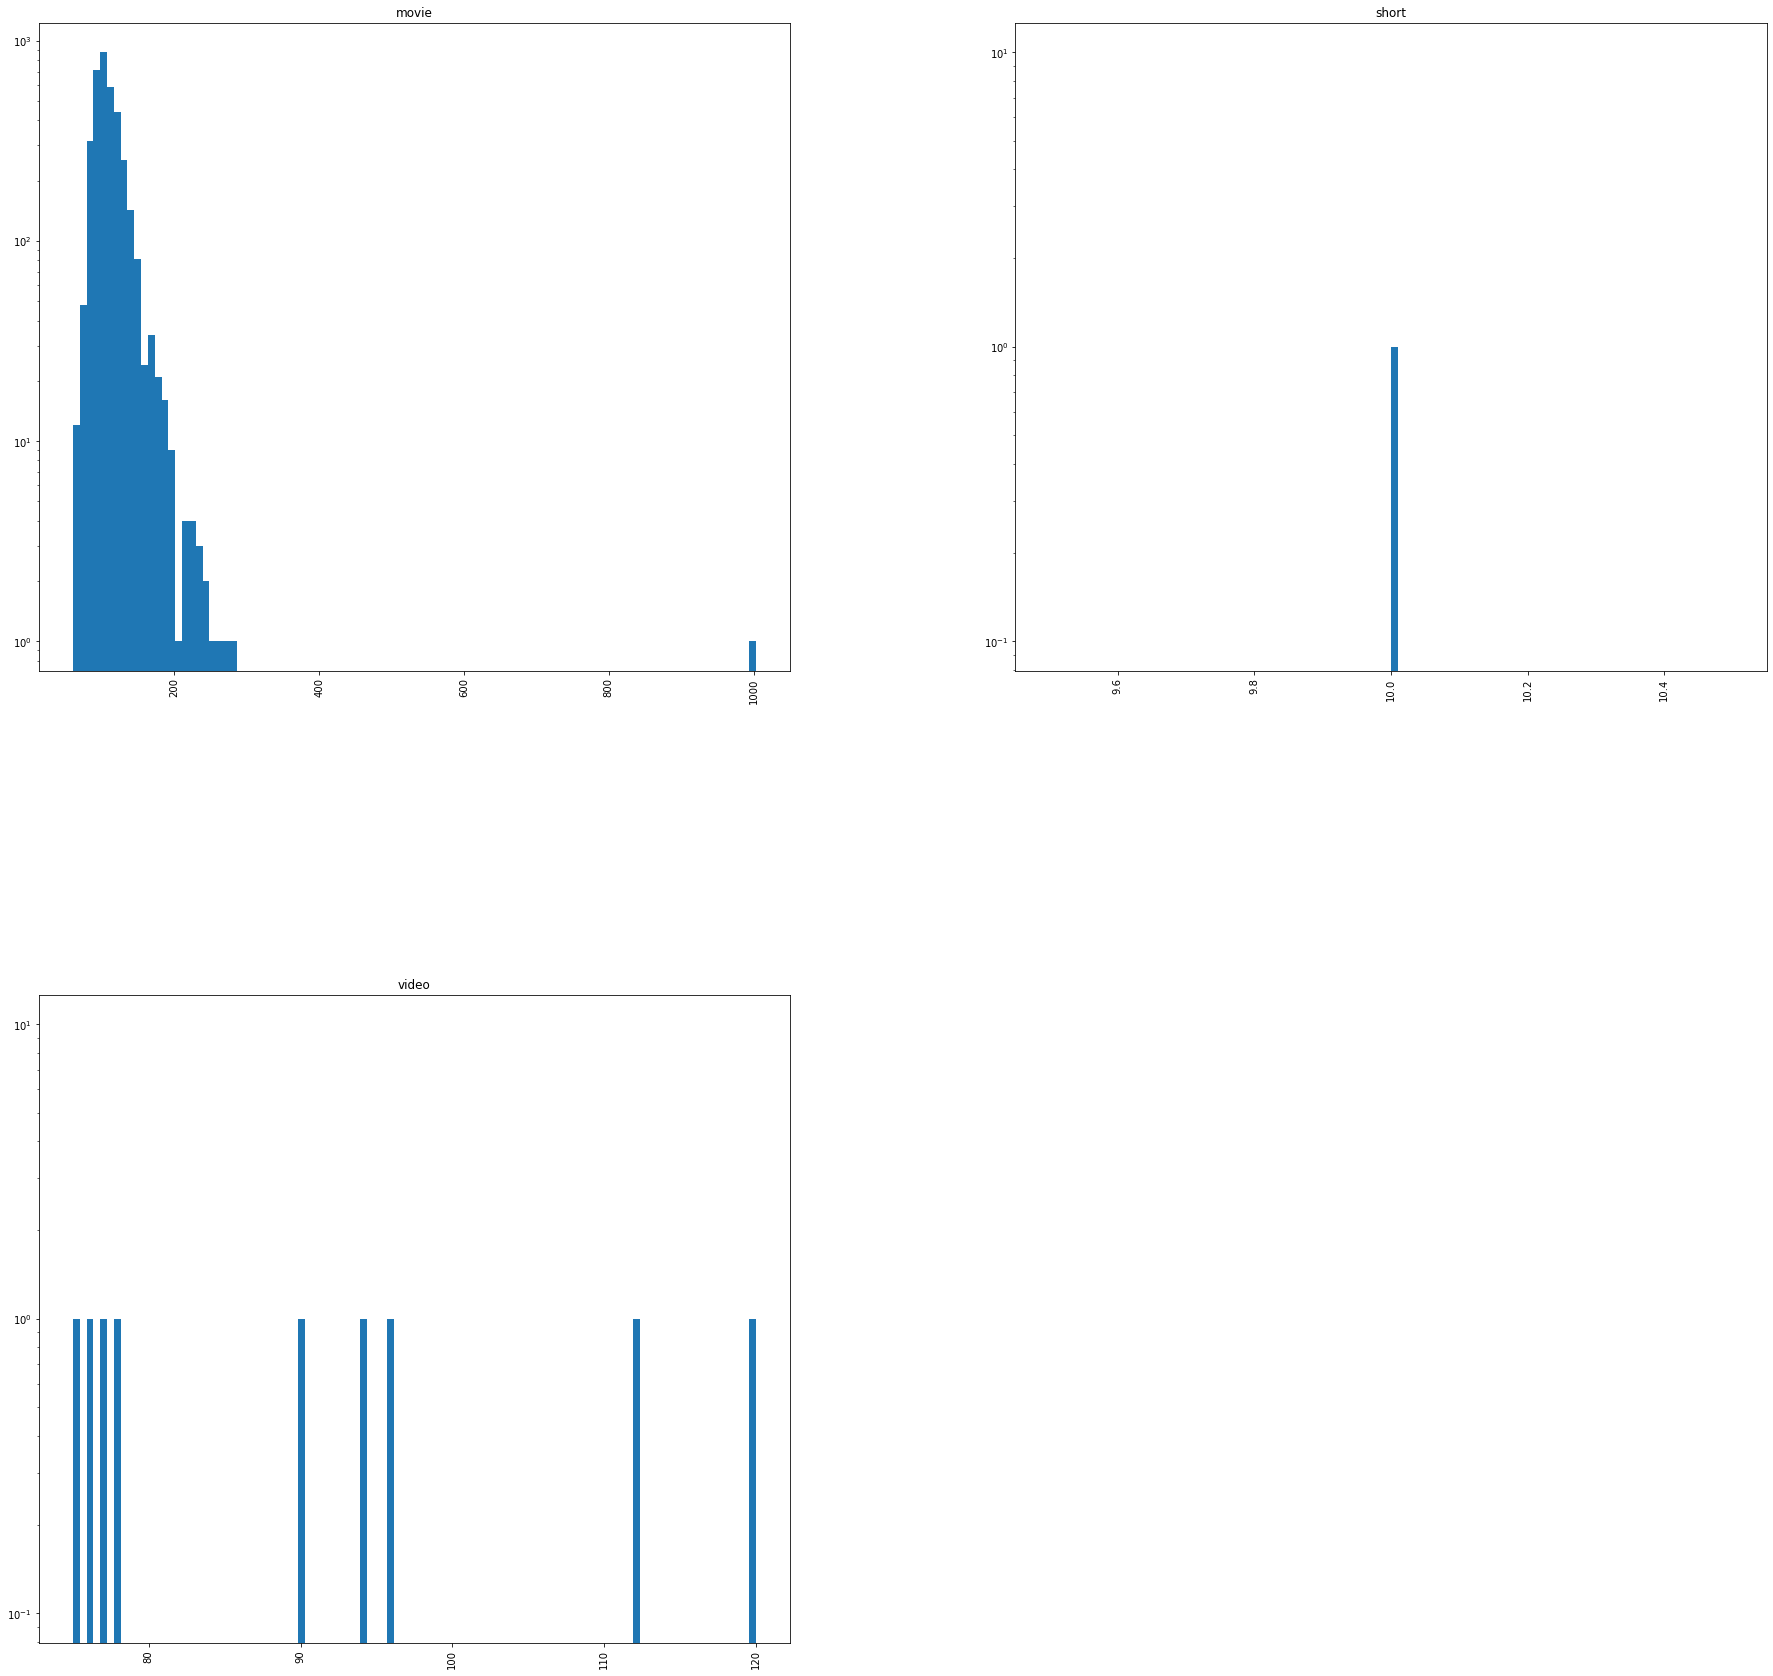

In [272]:
movies['runtime'].hist(bins=100,by=movies['titleType'],log=True,figsize=(30,30))
plt.title('Runtime')
plt.show()

#### Top languages, countries, and genres

Text(0.5, 1.0, 'plot of top 20 languages')

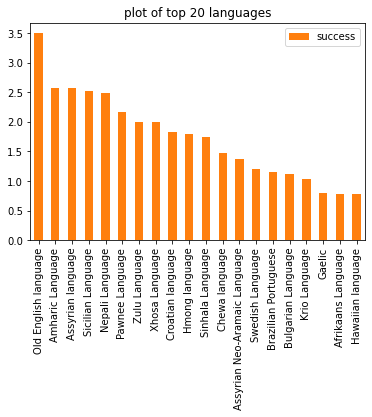

In [273]:
fig, axs = plt.subplots(1)
groupby_many(movies, movies['languages'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
##groupby_many(movies, movies['languages'])[['success']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 languages')


Text(0.5, 1.0, 'plot of top 20 countries')

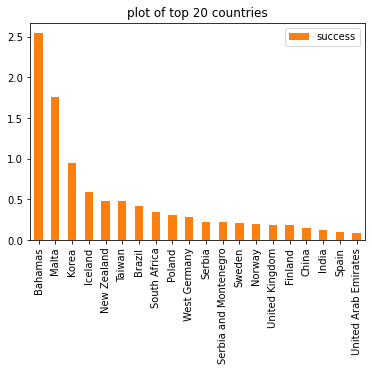

In [274]:
#groupby_many(movies_with_ratings, movies_with_ratings['countries'])[['averageRating', 'numVotes']].mean().sort_values('numVotes', ascending=False)[0:20].plot(kind='bar')
#plt.title('plot of 20 best rated countries')

fig, axs = plt.subplots(1)
groupby_many(movies, movies['countries'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 countries')

Text(0.5, 1.0, 'plot of top 20 genres')

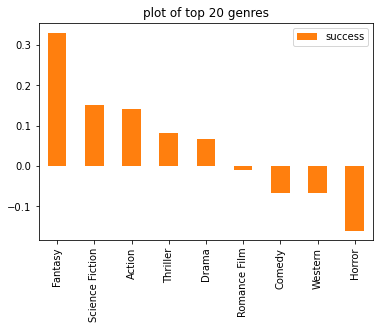

In [275]:
fig, axs = plt.subplots(1)
groupby_many(movies, movies['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 genres')




#### Each year's best genre

In [276]:
import ipywidgets as widgets
from ipywidgets import interact
slider=widgets.IntSlider(min=movies['year'].min(),max=movies['year'].max(),description='year')

interact(draw_plot1,year=slider)
#display(slider,out)

interactive(children=(IntSlider(value=1915, description='year', max=2012, min=1915), Output()), _dom_classes=(…

<function __main__.draw_plot1(year)>

#### The best countries for each genre

In [277]:
pairs = [(i, g) for (i, gg) in enumerate(movies['genres']) for g in gg]
row, group = zip(*pairs)
group=np.unique(group)
dd= widgets.Dropdown(options=group,value=group[0],description='Select a genre')

interact(draw_plot2,genre=dd)
#display(slider,out)

/opt/anaconda3/lib/python3.8/site-packages/traitlets/traitlets.py:586: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Select a genre', options=('Action', 'Comedy', 'Drama', 'Fantasy', …

<function __main__.draw_plot2(genre)>

Correlation between runtime and revenue (for normal timed movies: 50-200 minutes)

In [278]:
normal_time_movies= movies[((movies.runtime>=50) & (movies.runtime<=200))]
normal_time_movies.shape

(3583, 20)

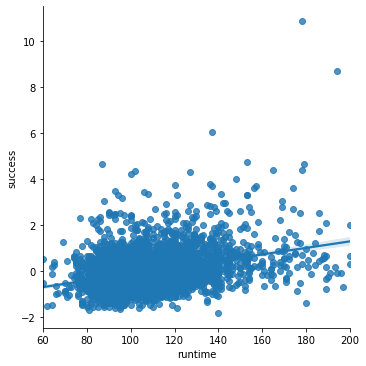

In [279]:
sns.lmplot(x='runtime', y='success', data=normal_time_movies[['success', 'runtime']])
plt.show()

In [280]:
#Linear dependence
normal_time_movies[['success', 'runtime']].corr()

,success,runtime
success,1.000000,0.334626
runtime,0.334626,1.000000


In [281]:
#Strength of association (spearman's correlation)
normal_time_movies.success.corr(normal_time_movies.runtime, method='spearman')

0.3182740691469318

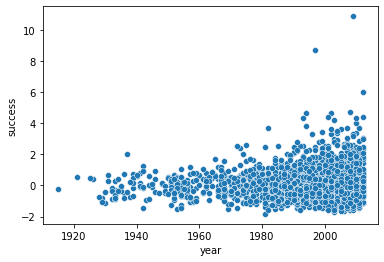

In [282]:
sns.scatterplot(x='year', y='success', data=normal_time_movies[['success', 'year']])
plt.show()

In [283]:
movies.columns
display(movies)

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,profit,weighted_rating,success
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Thriller, Horror, Action]",08-24,2001,tt0228333,movie,0,4.9,55237,tt0228333,28000000.0,1.124671,-0.552144,-0.963467,-0.757805
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],[Comedy],08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,-0.429220,-0.992895,-0.711058
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],[Drama],11-08,1989,tt0097499,movie,0,7.5,30168,tt0097499,9000000.0,1.161514,-0.432681,0.358668,-0.037006
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Comedy, Fantasy, Drama]",08-27,1964,tt0058331,movie,0,7.8,173216,tt0058331,6000000.0,4.882687,0.317291,1.285773,0.801532
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],[Drama],06-27,2001,tt0255819,movie,0,6.4,14988,tt0255819,16000000.0,1.07838,-0.336320,-0.518339,-0.427329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,10149834,Ponyo,202614288.0,101.0,[Japanese Language],[Japan],"[Fantasy, Drama]",07-19,2008,tt0876563,movie,0,7.6,144403,tt0876563,41677699.0,4.196854,0.827177,1.075424,0.951301
42575,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Thriller, Action]",01-10,1997,tt0120390,movie,0,4.9,11923,tt0120390,55000000.0,1.640388,-0.784540,-1.379856,-1.082198
42594,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Science Fiction, Thriller, Drama, Action]",03-11,2011,tt0945513,movie,0,7.5,520621,tt0945513,32000000.0,4.41211,0.467583,1.542670,1.005126
42612,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Comedy, Romance Film, Drama]",06-29,1988,tt0094898,movie,0,7.1,208557,tt0094898,39000000.0,2.50055,1.527505,0.890844,1.209175


<AxesSubplot:xlabel='month', ylabel='success'>

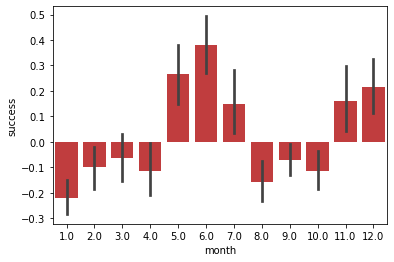

In [284]:
from datetime import datetime
movies['month'] = movies['month_day'].apply(lambda x :(int(x[1]) if x[0]=='0' else int(x[0:2])) if len(x)>0 else None)
df=movies.groupby(movies['month'])['success'].mean()
sns.barplot(data=movies,x=movies['month'],y=movies['success'],color='tab:red')

In [289]:
movies_for_reg= movies[['success','year','titleType','month']]
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm


mlb_g = MultiLabelBinarizer()

g=pd.DataFrame(mlb_g.fit_transform(movies['genres']),columns=mlb_g.classes_, index=movies.index)

movies_for_reg=pd.concat([movies_for_reg,g], axis=1)
movies_for_reg=pd.get_dummies(movies_for_reg)
movies_for_reg=movies_for_reg.dropna()
display(movies_for_reg)
X= sm.add_constant( movies_for_reg.drop('success', axis=1) )
model = sm.OLS(movies_for_reg['success'],X).fit()
print(model.summary())

,success,year,month,Action,Comedy,Drama,Fantasy,Horror,Romance Film,Science Fiction,Thriller,Western,titleType_movie,titleType_short,titleType_video
0,-0.757805,2001,8.0,1,0,0,0,1,0,1,1,0,1,0,0
4,-0.711058,1938,8.0,0,1,0,0,0,0,0,0,0,1,0,0
7,-0.037006,1989,11.0,0,0,1,0,0,0,0,0,0,1,0,0
8,0.801532,1964,8.0,0,1,1,1,0,0,0,0,0,1,0,0
15,-0.427329,2001,6.0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42559,-0.281049,1992,3.0,0,1,0,0,0,0,0,0,0,1,0,0
42565,0.951301,2008,7.0,0,0,1,1,0,0,0,0,0,1,0,0
42575,-1.082198,1997,1.0,1,0,0,0,0,0,0,1,0,1,0,0
42594,1.005126,2011,3.0,1,0,1,0,0,0,1,1,0,1,0,0


                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     15.47
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.07e-34
Time:                        18:50:19   Log-Likelihood:                -4124.1
No. Observations:                3344   AIC:                             8276.
Df Residuals:                    3330   BIC:                             8362.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.8496      1.605     

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


## Analyze the plot summaries

In [286]:
#!pip install -U gensim==3.8.3
#nltk.download('punkt') # For Stemming
#nltk.download('wordnet') # For Lemmatization
#nltk.download('stopwords') # For Stopword Removal
#nltk.download('omw-1.4')


In [287]:

stopwords = set(nltk.corpus.stopwords.words('english'))

# Remove URLs
def remove_url(text):
    return re.sub(r'https?:\S*','',text)

# Remove mentions and hashtags
def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*','',text)
    text = re.sub(r"\s*[A-Z]\w*\s*", " ", text)
    return re.sub(r'#\S*','',text)

def text_preprocessing(df):
    corpus=[]
    
    lem = WordNetLemmatizer() # For Lemmatization
    stem = PorterStemmer()
    for text in df['summary']:
        words=[w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        words=[stem.stem(w) for w in words]
        corpus.append(words)
    return corpus


In [288]:
principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']
min_success = 0.7


plots = plot_summary.merge(movies,on='wiki_movie_ID') ##.merge(movies[['wiki_movie_ID','averageRating','numVotes','genres']],on='wiki_movie_ID')

plots = plots[plots['success']>=min_success]
plots_by_genre = groupby_many(plots, plots['genres'])
pd.options.mode.chained_assignment = None
    

Action
 
Topic: 0 
Words: 0.010*"kill" + 0.008*"attack" + 0.008*"destroy" + 0.007*"escap" + 0.006*"return" + 0.006*"human" + 0.006*"find" + 0.006*"forc" + 0.006*"power" + 0.005*"use"
Topic: 1 
Words: 0.014*"kill" + 0.009*"escap" + 0.008*"find" + 0.007*"meet" + 0.007*"reveal" + 0.006*"car" + 0.006*"discov" + 0.006*"team" + 0.005*"attempt" + 0.005*"polic"
Topic: 2 
Words: 0.020*"-su" + 0.011*"-jin" + 0.010*"chalic" + 0.009*"-do" + 0.008*"sword" + 0.006*"love" + 0.005*"priest" + 0.005*"anim" + 0.005*"flood" + 0.005*"raider"
Topic: 3 
Words: 0.008*"take" + 0.007*"fight" + 0.007*"time" + 0.007*"father" + 0.007*"tell" + 0.006*"kill" + 0.005*"death" + 0.005*"life" + 0.005*"two" + 0.005*"give"
 
Comedy
 
Topic: 0 
Words: 0.007*"friend" + 0.007*"make" + 0.007*"tell" + 0.007*"meet" + 0.006*"love" + 0.006*"ask" + 0.006*"father" + 0.006*"get" + 0.006*"time" + 0.005*"home"
Topic: 1 
Words: 0.011*"find" + 0.007*"attempt" + 0.006*"escap" + 0.006*"tri" + 0.006*"take" + 0.006*"return" + 0.005*"get" + 0

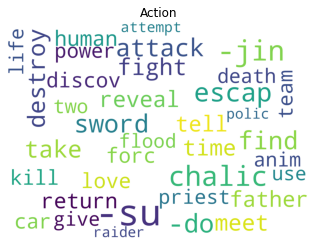

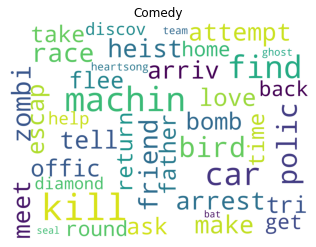

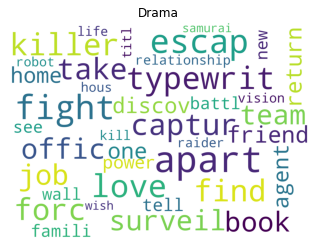

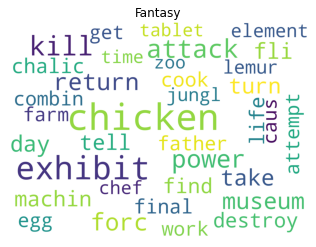

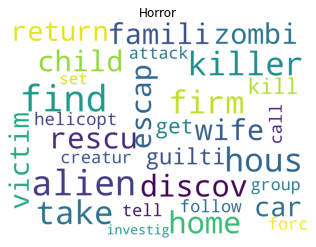

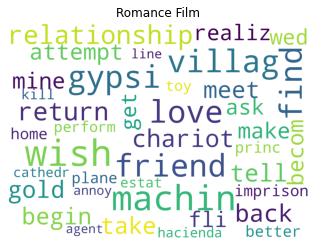

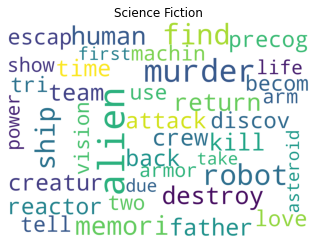

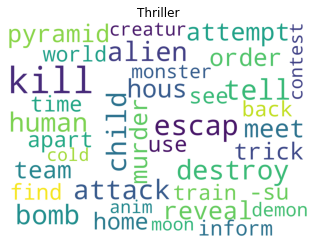

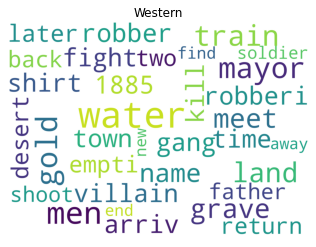

In [122]:
for genre in principal_genres : 

    print(genre)
    print(' ')
    genre_movies = plots_by_genre.get_group(genre)
    genre_movies['summary']=genre_movies['summary'].apply(remove_url)
    genre_movies['summary']=genre_movies['summary'].apply(remove_mentions_and_tags)
    corpus = text_preprocessing(genre_movies)
    # Transform to gensim dictionary
    dic = gensim.corpora.Dictionary(corpus) 
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    pickle.dump(bow_corpus, open('corpus_'+genre+'.pkl', 'wb'))
    dic.save('dictionary_'+genre+'.gensim')
    lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, id2word=dic,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
    
    # We print words occuring in each of the topics as we iterate through them
    for idx, topic in lda_model.print_topics(num_words=10):    
        print('Topic: {} \nWords: {}'.format(idx, topic))
        
    print(" ")
    topics = lda_model.show_topics(formatted=False)
    topic_words = {}
    for i in range(4):
        topic_words.update(dict(topics[i][1]))
    cloud = WordCloud(background_color='white',width=2500,height=1800,)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    fig = plt.figure()
    plt.gca().set_title(genre)
    plt.gca().axis('off')
    plt.imshow(cloud)